<a href="https://colab.research.google.com/github/Tinynja/Sarsa-phi-EB/blob/main/notebooks/Sarsa_Phi_EB_IMPROVED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download required files from GitHub repo
import sys

if 'google.colab' in sys.modules:
    !rm -rf *
    !git clone https://github.com/Tinynja/Sarsa-phi-EB
    !mv Sarsa-phi-EB/* .
    !rm -rf Sarsa-phi-EB
    # DON'T install packages defined in Pipfile_Colab_exclude
    !sed -ri "/$(tr '\n' '|' < Pipfile_Colab_exclude)/d" Pipfile
else:
    print('Skipping GitHub cloning since not running in Colab.')

Cloning into 'Sarsa-phi-EB'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 418 (delta 11), reused 19 (delta 7), pack-reused 389
Receiving objects: 100% (418/418), 4.64 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [ ]:
# Install required dependencies
import os

if 'google.colab' in sys.modules:
    # Some dependencies required for displaying episode
    !apt-get update 1> /dev/null
    !apt-get install -y python-opengl xvfb 1> /dev/null
    !pip install pyvirtualdisplay 1> /dev/null
    # Colab doesn't support pipenv, hence we convert Pipfile into requirements.txt
    if 'requirements_Colab.txt' not in os.listdir():
        !pip install pipenv
        !pipenv lock -r > requirements.txt
    !pip install -r requirements_Colab.txt
else:
    !pipenv install 1> /dev/null

  Using cached ale_py-0.7.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Import all supported ROMs into ALE
!ale-import-roms ROMS

[SUPPORTED]                  hangman ROMS/Hangman - Spelling (1978).bin
[SUPPORTED]                tutankham      ROMS/Tutankham (1983).bin
[SUPPORTED]                 kangaroo       ROMS/Kangaroo (1983).bin
[SUPPORTED]                frostbite      ROMS/Frostbite (1983).bin
[SUPPORTED]                  asterix ROMS/Asterix (AKA Taz) (1983).bin
[SUPPORTED]          keystone_kapers ROMS/Keystone Kapers - Raueber und Gendarm (1983).bin
[SUPPORTED]               beam_rider      ROMS/Beamrider (1984).bin
[SUPPORTED]                  bowling        ROMS/Bowling (1979).bin
[SUPPORTED]                 trondead ROMS/TRON - Deadly Discs (TRON Joystick) (1983).bin
[SUPPORTED]          elevator_action ROMS/Elevator Action (1983).bin
[SUPPORTED]                    qbert         ROMS/Q-bert (1983).bin
[SUPPORTED]                    qbert        ROMS/Q. Bert (1983).bin
[SUPPORTED]                    alien          ROMS/Alien (1982).bin
[SUPPORTED]               videochess ROMS/Video Chess (Computer 

In [ ]:
#### ALE-related imports ####

# Built-in libraries
import re
import sys
import timeit
import base64
import pickle
import logging
import subprocess
from pathlib import Path
from datetime import datetime

# Pypi libraries
import gym
import torch
import pandas as pd
import matplotlib.pyplot as plt
from ale_py import ALEInterface, SDL_SUPPORT
import ale_py.roms as ROMS

# Episode display
from PIL import Image
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
Display().start()

# Configuration
CUDA = 'cuda' if torch.cuda.device_count() else 'cpu'
CPU = 'cpu'

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [ ]:
class EnvRecorder:
    def __init__(self, env, out_dir='./results'):
        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(exist_ok=True)
        self.out_dir = self.out_dir.resolve()
        self.env = env

        # Workspace variables
        self.__frame_count_padding = 0
        self.__timestep = 0
    
    def __call__(self, choose_action=None, max_steps=-1, height=300):
        self.record_episode_and_show(choose_action=choose_action, max_steps=max_steps, height=height)
    
    def record_episode_and_show(self, choose_action=None, max_steps=-1, height=300):
        self.record_episode(choose_action=choose_action, max_steps=max_steps)
        self.show_recording(height=height)
    
    def record_episode(self, choose_action=None, max_steps=-1):
        """Generate an episode and record it as record.mp4
        Args:
        choose_action -- callable method that returns the next action based on the current observation
        max_steps     -- maximum number of steps after which force end episode
        """
        choose_action = choose_action or (lambda _: self.env.action_space.sample())

        self._clear_recording()
        self.__timestep, done, observation =  0, False, self.env.reset()
        self._record_frame()
        while not done and self.__timestep != max_steps:
            print(f'\rRecording episode, timestep {self.__timestep+1}...', end='')
            action = choose_action(observation)
            observation, _, done, _ = self.env.step(action)
            self.__timestep += 1
            self._record_frame()

        if self.__timestep == max_steps and not done:
            print('\nWarning: `max_steps` reached before episode terminated')
        else:
            print()

        self._export_as_mp4()

    def show_recording(self, height=300):
        """Show a .mp4 video in html format of the recorded episode"""
        filepath = self.out_dir.joinpath('record.mp4')
        video_b64 = base64.b64encode(filepath.read_bytes())
        html = f'''<video alt="{filepath}" autoplay loop controls style="height:{height}px">
                        <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
                   </video>'''
        ipythondisplay.display(ipythondisplay.HTML(data=html))

    def _clear_recording(self):
        # This is a new episode, delete previously recorded steps
        self.out_dir.joinpath('record').mkdir(exist_ok=True)
        for step_png in self.out_dir.glob('record/step_*.png'):
            step_png.unlink()
        if self.out_dir.joinpath('record.mp4').exists():
            self.out_dir.joinpath('record.mp4').unlink()
    
    def _record_frame(self):
        # Record current timestep png
        img = Image.fromarray(env.render('rgb_array'))
        out_path = self.out_dir.joinpath(f'record/step_{self.__timestep}.png')
        img.save(str(out_path))

    def _export_as_mp4(self):
        """Convert the recorded set of png files into an mp4 video"""
        self._standardize_frame_count_padding()
        in_dir = self.out_dir.joinpath('record')
        in_pattern = f'step_%0{self.__frame_count_padding}d.png'
        out_file = self.out_dir.joinpath('record.mp4')
        !cd $in_dir; ffmpeg -hide_banner -loglevel error -r 60 -i $in_pattern -vcodec libx264 -crf 25 -pix_fmt yuv420p -y $out_file
    
    def _standardize_frame_count_padding(self):
        self.__frame_count_padding = len(str(self.__timestep))
        number_pattern = re.compile('\d+')
        png_abs_glob = 'step_*.png'
        for png_path in self.out_dir.joinpath('record').glob(png_abs_glob):
            ts = int(number_pattern.search(png_path.stem).group(0))
            new_name = png_path.parent.joinpath(f'step_{ts:0{self.__frame_count_padding}d}.png')
            png_path.rename(new_name)

In [ ]:
def cbrt(x):
    if x >= 0:
        return x**(1/3)
    else:
        return -(-x)**(1/3)


class features:
    @staticmethod
    def basic(frame, palette, background, crop_size=torch.Tensor([15,10]), flatten=True):
        # For each color in palette, tell if each pixel is that color (e.g. 210,160,128)
        colors_in_pixels = ((frame-background).unsqueeze(-2) == palette).all(-1)
        # Split the image into n tiles, each with dimension `crop_size` (e.g. 14,16,15,10,128)
        cropped_colors_in_pixels = torch.stack(torch.stack(colors_in_pixels.split(crop_size[1],dim=-2)).split(crop_size[0],dim=-3))
        # Apply logical or inside each cropped image (e.g. 14,16,128)
        cropped_features = cropped_colors_in_pixels.any(3).any(2)
        # Flatten the features (e.g. 28672)
        return cropped_features.flatten() if flatten else cropped_features
    
    @staticmethod
    def b_pros(frame, palette, background, crop_size=torch.Tensor([15,10])):
        raise NotImplementedError()
        basic_features = features.basic(frame, palette, background, crop_size=crop_size)
        b_pros_features = torch.combinations(basic_features)
        return b_pros_features
    
    @staticmethod
    def discretized_float(number, low, high, n_intervals):
        feature = torch.zeros(n_intervals+2, dtype=torch.bool)
        if number < low:
            feature[0] = True
        elif number >= high:
            feature[-1] = True
        else:
            index = int( n_intervals/2 * ( 1 + cbrt( (number-(high+low)/2) / ((high-low)/2) ) ) )
            feature[index+1] = True
        return feature

In [ ]:
class BinaryEnv:
    def __init__(self, env_name, n_features, device=CUDA, *args, **kwargs):
        self.env = gym.make(env_name, *args, **kwargs)
        self.n_features = int(n_features/self.env.observation_space.shape[0])
        self.device = device

        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

        self._overwrite_obs_high_low()
    
    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        return self._binarize_observation(observation)

    def step(self, *args, **kwargs):
        observation, reward, done, info = self.env.step(*args, **kwargs)
        observation = self._binarize_observation(observation)
        return observation, reward, done, info

    def render(self, *args, **kwargs):
        return self.env.render(*args, **kwargs)
    
    def _overwrite_obs_high_low(self):
        if self.env.spec.id.startswith('CartPole'):
            self.env.observation_space.low[[1,3]] = -4, -7
            self.env.observation_space.high[[1,3]] = 4, 7
    
    def _binarize_observation(self, observation):
        bin_features = []
        lows, highs = self.env.observation_space.low, self.env.observation_space.high
        for i,obs in enumerate(observation):
            bin_features.append(features.discretized_float(obs, lows[i], highs[i], n_intervals=self.n_features))
        return torch.cat(bin_features).to(self.device)

In [ ]:
from gym.spaces import Discrete, Box

class EnvALE:
    def __init__(self, rom, out_dir='results', seed=0, feature_type='ScreenRGB',
                 regen_bg=False, bg_samples=18000, device=CUDA):
        self.rom = rom
        self.rom_name = rom.stem
        self.feature_type = feature_type
        self.device = device

        self.out_dir = Path(out_dir)
        self.out_dir.mkdir(exist_ok=True)
        self.out_dir = self.out_dir.resolve()

        # ALE
        self.ale = ALEInterface()
        self.ale.setInt("random_seed", seed)
        self.ale.loadROM(rom)

        # gym action_space compatibility
        action_set = self.ale.getMinimalActionSet()
        self.action_space = Discrete(len(action_set))
        self.action_space.action_set = action_set

        # color palette
        self.color_palette = self._get_color_palette().to(self.device)

        self._bg_path = Path(f'./backgrounds/{self.rom_name}.pickle')
        if regen_bg or not self._bg_path.exists() or not self._bg_path.is_file():
            self.background = self._get_background(n_samples=bg_samples)
        else:
            with open(self._bg_path, 'rb') as file:
                self.background = pickle.load(file).to(self.device)
        
        self._set_observe_method(feature_type)
        self.observation_space = Box(low=0, high=1, shape=self._observe().shape, dtype=bool)

    def reset(self, do_record=False):
        self.ale.reset_game()
        observation = self._observe()
        
        return observation
        
    def step(self, action):
        if isinstance(action, int):
            action = self.action_space.action_set[action]

        reward = self.ale.act(action)
        observation = self._observe()
        done = self.ale.game_over()
                
        return observation, reward, done, None

    def render(self, mode='rgb_array'):
        if mode == 'rgb_array':
            return self.ale.getScreenRGB()
        else:
            raise ValueError(f'render mode `{mode}` is not supported')

    def _set_observe_method(self, feature_type):
        if feature_type == 'ScreenRGB':
            self._observe = lambda: torch.from_numpy(self.ale.getScreenRGB()).to(self.device)
        elif feature_type == 'ScreenGrayscale':
            self._observe = lambda: torch.from_numpy(self.ale.getScreenGrayscale()).to(self.device)
        elif feature_type == 'Basic':
            self._observe = lambda: features.basic(frame=torch.from_numpy(self.ale.getScreenRGB()).to(self.device),
                                                   palette=self.color_palette,
                                                   background=self.background)
        elif feature_type == 'B-PROS':
            self._observe = lambda: features.b_pros(frame=torch.from_numpy(self.ale.getScreenRGB()).to(self.device),
                                                    palette=self.color_palette,
                                                    background=self.background)
        else:
            raise NotImplementedError(f'Feature type `{feature_type}` is not supported')
        
    def _observe(self):
        raise NotImplementedError()
    
    def _get_color_palette(self):
        result = subprocess.run(['python', '-c', f'__import__("ale_py").ALEInterface().loadROM("{str(self.rom)}")'], capture_output=True)
        palette_name = result.stderr.decode().splitlines()[6].strip().split()[-1]
        with open(f'palettes/{palette_name}_Palette.pickle', 'rb') as file:
            palette = pickle.load(file)
        return palette
    
    def _get_background(self, n_samples):
        bg_feature_type = 'ScreenRGB' if self.feature_type not in ['ScreenGrayscale',] else 'ScreenGrayscale'
        self._set_observe_method(bg_feature_type)
        
        sample_i = 0
        pixel_histogram = torch.zeros((*self.ale.getScreenDims(), self.color_palette.shape[0]), dtype=torch.int32).to(self.device)
        while sample_i < n_samples:
            done, observation = False, self.reset()
            while not done and sample_i < n_samples:
                if not sample_i%10:
                    print(f'\rGenerating background... {sample_i}/{n_samples} samples ({sample_i/n_samples:.0%})', end='')
                action = self.action_space.sample()
                observation, reward, done, info = self.step(action)
                colors_in_pixels = (observation.unsqueeze(-2) == self.color_palette).all(-1)
                pixel_histogram += colors_in_pixels
                sample_i += 1
        print('\r', end='')
        background_ids = pixel_histogram.argmax(axis=-1)
        background = self.color_palette[background_ids]
        
        self._bg_path.parent.mkdir(exist_ok=True)
        with open(self._bg_path, 'wb') as file:
            pickle.dump(background.cpu(), file)
        
        return background

In [ ]:
#@title

if print("Skipped background regeneration."):
# if True:

    from ale_py.roms import *
    games_to_generate_bg = [Breakout, MontezumaRevenge, Venture, Qbert, Frostbite, Freeway]

    for game in games_to_generate_bg:
        print(f'\n{game.stem}')
        env = EnvALE(game, regen_bg=True, bg_samples=100)
        bg_np = env.background.cpu().to(torch.uint8).numpy()
        display(Image.fromarray(bg_np))

Skipped background regeneration.


In [ ]:
#@title

if print("Skipped displaying stored backgrounds to reduce ouptuts."):
# if True:

    for filepath in Path('backgrounds').iterdir():
        print(f'\nBackground in `{filepath.resolve()}`')
        with open(filepath, 'rb') as file:
            bg = pickle.load(file)
        display(Image.fromarray(bg.to(torch.uint8).numpy()))

Skipped displaying stored backgrounds to reduce ouptuts.


In [ ]:
#@title

if print("Skipped episode display manual test."):
# if True:

    env = EnvALE(ROMS.Breakout)
    recorder = EnvRecorder(env)
    recorder()

Skipped episode display manual test.


In [ ]:
from math import ceil

class PrintJustEnough:
    def __init__(self, time_interval=0.5):
        self._print_interval = 1
        self._print_count = 0
        self.time_interval = time_interval
        self._calibrated = False
        self.reset_calibration()
    
    def reset_calibration(self):
        self._calib_start = None
        self._calib_count = 0
        self._calibrated = False
    
    def print(self, *args, **kwargs):
        if self._calibrated:
            self._print_count += 1
            if not self._print_count%self._print_interval:
                print(*args, **kwargs)
                self._print_count = 0
        else:
            self._handle_calibration()
        
    def _handle_calibration(self):
        self._calib_count += 1
        curr_time = timeit.default_timer()
        if self._calib_start is None:
            self._calib_start = curr_time
        if curr_time-self._calib_start > 1:
            self._print_interval = ceil(self.time_interval*self._calib_count/(curr_time-self._calib_start))
            self._calibrated = True
    
    def __call__(self, *args, **kwargs):
        self.print(*args, **kwargs)

pje = PrintJustEnough()

In [ ]:
class SarsaPhiEBAgent:
    def __init__(self, env, gamma=0.99, epsilon=0.01, alpha=0.5, lam=0.9, beta=0.05, init_action=1, step_repeat_count=1, device=CUDA, debug=False):
        """An agent using Sarsa(lambda) algorithm with:
            - Linear Function Approximation (SGD)
            - Replacing Traces
            - Exploration-Bonus
        
        Args:
                      env -- gym-like environment
                    alpha -- step size
                    gamma -- discount factor
                      lam -- trace decay
                     beta -- exploration bonus parameter
              init_action -- action to take after an environment reset
        step_repeat_count -- numer of times to repeat an action every timestep (under-the-hood) 
                   device -- device on which to store tensors
                    debug -- enable debug output
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.lam = lam
        self.beta = beta
        self.init_action = init_action
        self.step_repeat_count = step_repeat_count
        self.device = device

        self.__log = logging.Logger(name=self.__class__.__name__,
                                    level=(logging.DEBUG if debug else logging.WARNING))

        # Workspace variables
        self.feature_space_shape = (self.env.action_space.n, *self.env.reset().shape)
        self.weights = torch.zeros(self.feature_space_shape).to(self.device)
        self._counts = torch.zeros(self.feature_space_shape).to(self.device)
        self._total_timesteps, self._total_episodes = 0, 0
        self.rewards = []

    # def learn_timesteps(self, epochs, do_print=True):
    #     start_time, total_rewards, done = timeit.default_timer(), 'INIT', True
    #     curr_epoch = 0
    #     pje.reset_calibration()
    #     while curr_epoch != epochs:
    #         # Reset env when episode ends
    #         if done:
    #             if total_rewards != 'INIT':
    #                 self.rewards.append(float(total_rewards))
    #             next_phi = self.env.reset()
    #             total_rewards = 0
    #             if self.init_action is not None:
    #                 next_phi, reward, done, _ = self.env.step(self.init_action)
    #                 total_rewards += reward
    #             next_action = self._choose_action(next_phi)
    #             traces = torch.zeros(self.feature_space_shape).to(self.device)
    #             if epochs_as_episodes:
    #                 curr_epoch += 1
    #                 if do_print:
    #                     avg_time = (timeit.default_timer()-start_time)/(curr_epoch or 1)
    #                     pje(f'\rSarsaPhiEB learning iteration {self._total_steps}/{self._total_steps-curr_epoch+epochs} ({1000*avg_time:.2f}ms/iter, remaining {(epochs-curr_epoch)*avg_time:.0f}s)    ', end='')

    #         if not epochs_as_episodes:
    #             curr_epoch += 1
    #             # Information display
    #             if do_print:
    #                 avg_time = (timeit.default_timer()-start_time)/(curr_epoch or 1)
    #                 pje(f'\rSarsaPhiEB learning iteration {self._total_steps}/{self._total_steps-curr_epoch+epochs} ({1000*avg_time:.2f}ms/iter, remaining {(epochs-curr_epoch)*avg_time:.0f}s)    ', end='')

    #         # Advance to next timestep
    #         phi, action = next_phi, next_action
    #         active_features = phi.nonzero()
    #         self._total_steps += 1

    #         # Take an action
    #         next_phi, reward, done, _ = self._step_repeat(action)
    #         next_action = self._choose_action(next_phi)
    #         total_rewards += reward

    #         # Apply exploration bonus
    #         self._counts[action,active_features] += 1
    #         reward += self._calc_exploration_bonus(phi, action)

    #         # RL Algorithm : Sarsa(lambda) LFA(SGD) Replacing Traces
    #         traces *= self.gamma * self.lam
    #         traces[action, active_features] = phi[active_features].to(traces.dtype)
    #         if not done:
    #             delta = reward + self.gamma * self._action_value(next_phi, next_action) - self._action_value(phi, action)
    #         else:
    #             # In terminal state, all state-action values are 0
    #             delta = reward + 0 - self._action_value(phi, action)
    #         if self.alpha * delta * traces.isnan().any():
    #             # print(self.weights.unique())
    #             print(self._action_value(phi, action))
    #             # print(phi)
    #             # print(action)
    #             # print(traces.unique())
    #         self.weights += self.alpha * delta * traces

    #         # print('traces', traces.nonzero())
    #         # __import__('time').sleep(1)
    #         # return locals()
    #         # if reward > 0:
    #         #     print(f'ITERATION {i}')
    #         #     print('REWARD', reward)
    #         #     # return self.weights, phi
    #         # if self.weights.max() > 1:
    #         #     print(f'ITERATION {i}')
    #         #     print('alpha', self.alpha)
    #         #     print('delta', delta)
    #         #     print('reward', reward)
    #         #     print('weight_sum', self.weights[action].sum())
    #         #     print('next_action_value', self._action_value(phi, action))
    #         #     print('action_value', self._action_value(next_phi, next_action))
    #         #     # print(traces.unique())
    #         #     # print(self.weights[action].unique().sum())
    #         #     break
        
    #     print(f'\rSarsaPhiEB learning iteration {self._total_steps}/{self._total_steps-i+epochs-1} ({1000*avg_time:.2f}ms/iter, remaining {(epochs-i)*avg_time:.0f}s)    ', end='')
    #     print(f'\nTotal elapsed time: {datetime.utcfromtimestamp(timeit.default_timer()-start_time).strftime("%H:%M:%S.%f")}')

    def learn_episodes(self, epochs, do_print=True, eps_pc=1e-4):
        start_time, avg_time, curr_epoch, total_rewards, done = timeit.default_timer(), 0, 0, 'INIT', True
        prev_start_time = start_time
        while curr_epoch != epochs:
            # Reset env when episode ends
            if done:
                if total_rewards != 'INIT':
                    self.rewards.append(total_rewards)
                    self._total_episodes += 1
                    curr_epoch += 1
                next_phi = self.env.reset()
                total_rewards = 0
                if self.init_action is not None:
                    next_phi, reward, done, _ = self.env.step(self.init_action)
                    total_rewards += reward
                next_action = self._choose_action(next_phi)
                traces = torch.zeros(self.feature_space_shape).to(self.device)
                if do_print:
                    end_time = timeit.default_timer()
                    avg_time = 0.99*avg_time + 0.01*(end_time-prev_start_time)
                    prev_start_time = end_time
                    pje(f'\rSarsaPhiEB learning episode {self._total_episodes}/{self._total_episodes-curr_epoch+epochs} ({1000*avg_time:.2f}ms/episode, remaining {(epochs-curr_epoch)*avg_time:.0f}s)    ', end='')

            # Advance to next timestep
            phi, action = next_phi, next_action
            active_features = phi.nonzero()
            self._total_timesteps += 1

            # Take an action
            next_phi, reward, done, _ = self._step_repeat(action)
            next_action = self._choose_action(next_phi)
            total_rewards += reward

            # Apply exploration bonus
            self._counts[action,active_features] += 1
            reward += self._calc_exploration_bonus(phi, action, eps_pc=eps_pc)

            # RL Algorithm : Sarsa(lambda) LFA(SGD) Replacing Traces
            traces *= self.gamma * self.lam
            traces[action, active_features] = phi[active_features].to(traces.dtype)
            if not done:
                delta = reward + self.gamma * self._action_value(next_phi, next_action) - self._action_value(phi, action)
            else:
                # In terminal state, all state-action values are 0
                delta = reward + 0 - self._action_value(phi, action)
            self.weights += self.alpha * delta * traces
        
        if do_print:
            print(f'\rSarsaPhiEB learning episode {self._total_episodes}/{self._total_episodes-curr_epoch+epochs} ({1000*avg_time:.2f}ms/episode, remaining {(epochs-curr_epoch)*avg_time:.0f}s)    ', end='')
            print(f'\nTotal elapsed time: {datetime.utcfromtimestamp(timeit.default_timer()-start_time).strftime("%H:%M:%S.%f")}')
    
    def _step_repeat(self, action):
        reward = 0
        for i in range(self.step_repeat_count):
            observation, sub_reward, done, info = self.env.step(action)
            reward += sub_reward
            if done: break
        return observation, reward, done, info
    
    def _action_value(self, phi, action):
        return (self.weights[action]@phi.to(self.weights.dtype)).item()
    
    def _choose_action(self, phi):
        if torch.rand(1) > self.epsilon:
            action_values = self.weights@phi.to(self.weights.dtype)
            best_actions = (action_values == action_values.max()).nonzero()
            # Tie-breaker
            action = best_actions[torch.randint(len(best_actions), (1,))]
            return action.item()
        else:
            return self.env.action_space.sample()
    
    def _calc_exploration_bonus(self, phi, action, eps_pc=1e-2):
        # Compute the exploration bonus
        phi_occ = torch.cat((self._counts[action, phi], self._total_timesteps-self._counts[action, ~phi])).to(self.device)
        rho = ((phi_occ+1/2) / (self._total_timesteps+1)).prod()
        rho_prime = ((phi_occ+1+1/2) / (self._total_timesteps+1+1)).prod()
        pseudocount = (rho*(1-rho_prime)) / (rho_prime-rho)
        if pseudocount.isnan() or pseudocount.isinf() or pseudocount == 0:
            pseudocount = torch.Tensor([eps_pc]).to(self.device)
        exploration_bonus = self.beta / pseudocount.sqrt()
        return exploration_bonus

In [ ]:
def moving_average(table, step_size=0.03, initial_value=None):
    avg = table[0] if initial_value is None else initial_value
    table_avg = []
    for r in table:
        avg += 0.03*(r - avg)
        table_avg.append(avg)
    return table_avg

In [ ]:
#@title

if print("Skipped agent learning manual test."):
# if True:

    env = BinaryEnv('CartPole-v1', n_features=2000, device=CPU)
    agent = SarsaPhiEBAgent(env, alpha=0.05, device=env.device)
    recorder = EnvRecorder(env)
    agent.learn_episodes(500)
    plt.plot(agent.rewards)
    plt.show()
    plt.plot(moving_average(agent.rewards, initial_value=0))
    plt.show()
    recorder(choose_action=agent._choose_action)

Skipped agent learning manual test.


In [ ]:
test_alphas =  [0.01, 0.02, 0.05, 0.1, 0.25, 0.5]
test_features = [600, 800, 1200, 1600, 2400]

epochs = 1000
runs = 10
gridsearch_alpha_nfeatures = pd.DataFrame(columns=['alpha', 'n_features', 'runs', 'rewards_history'])

for i,alpha in enumerate(test_alphas):
    for j,n_features in enumerate(test_features):
        rewards = torch.zeros(epochs)
        for k in range(runs): #add repetition to lower variance (make graphs more readable)
            print(f'\rGridsearch {i*len(test_features)+j+1}/{len(test_alphas)*len(test_features)} (alpha={alpha}, n_features={n_features}, run {k+1}/{runs})', end='')
            env = BinaryEnv('CartPole-v1', n_features=n_features, device=CPU)
            agent = SarsaPhiEBAgent(env, alpha=alpha, device=env.device)
            agent.learn_episodes(epochs, do_print=False)
            rewards += torch.Tensor(agent.rewards)
        rewards /= runs
        gridsearch_alpha_nfeatures = gridsearch_alpha_nfeatures.append([{'alpha':alpha, 'n_features':n_features, 'runs':runs, 'rewards_history':rewards.tolist()}], ignore_index=True)

results_dir = Path('./results')
results_dir.mkdir(exist_ok=True)
with open(results_dir.joinpath('gridsearch_alpha_nfeatures'), 'wb') as file:
    pickle.dump(gridsearch_alpha_nfeatures, file)

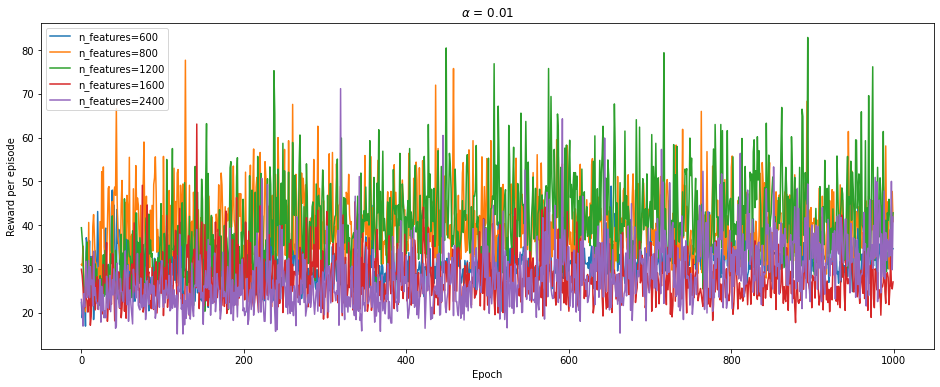

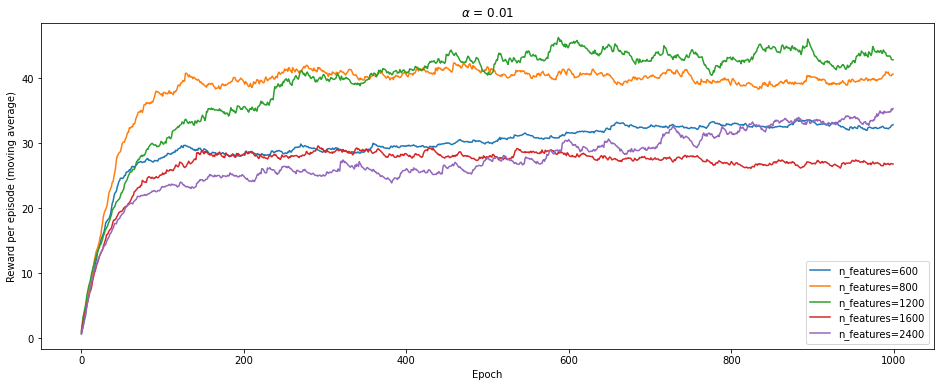

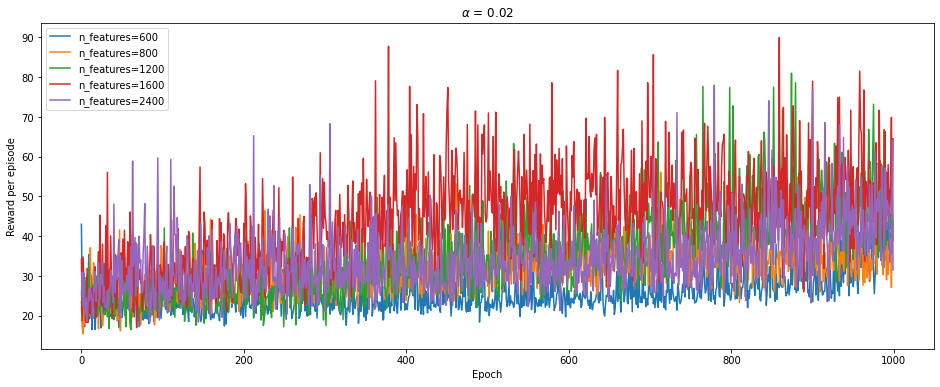

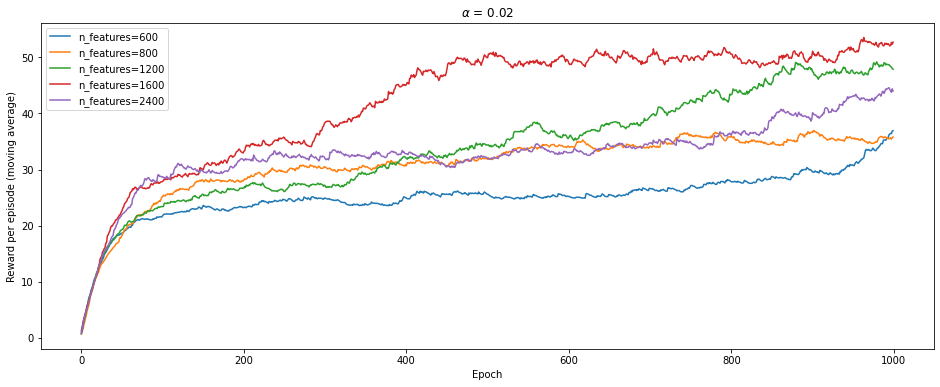

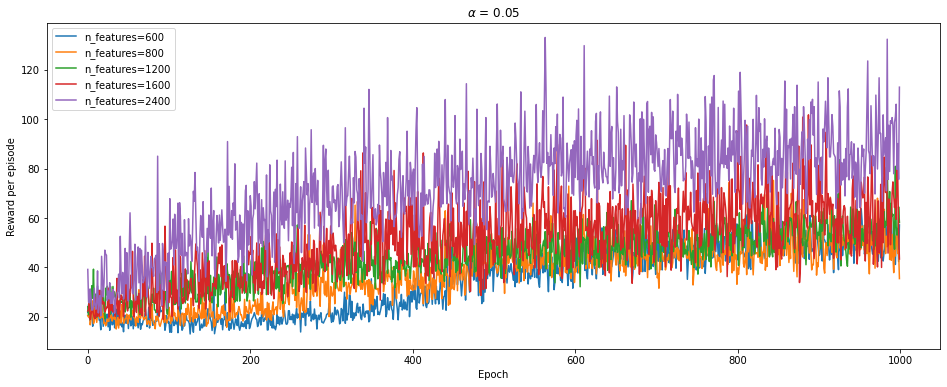

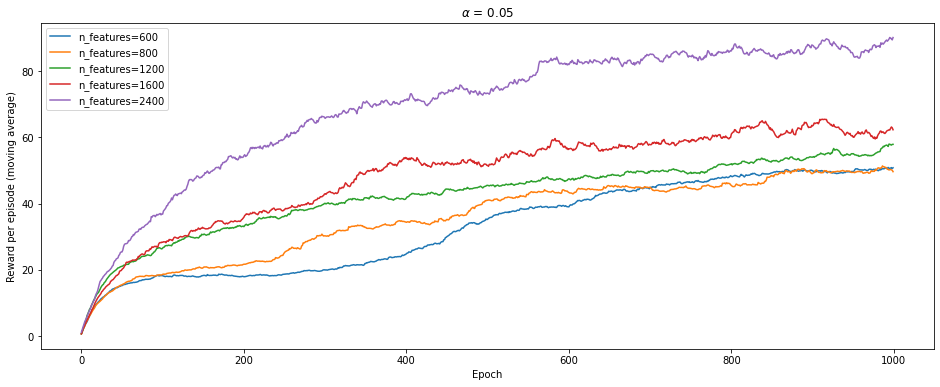

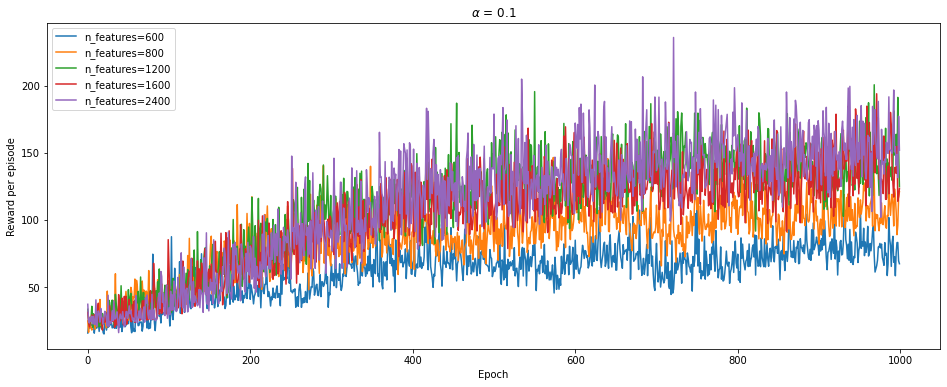

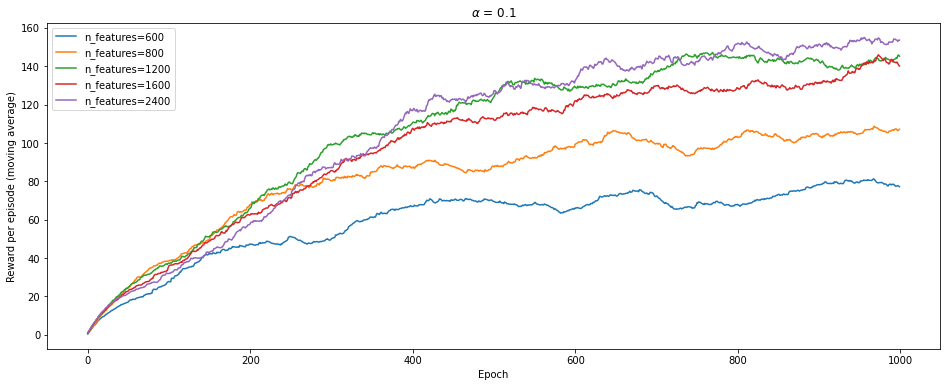

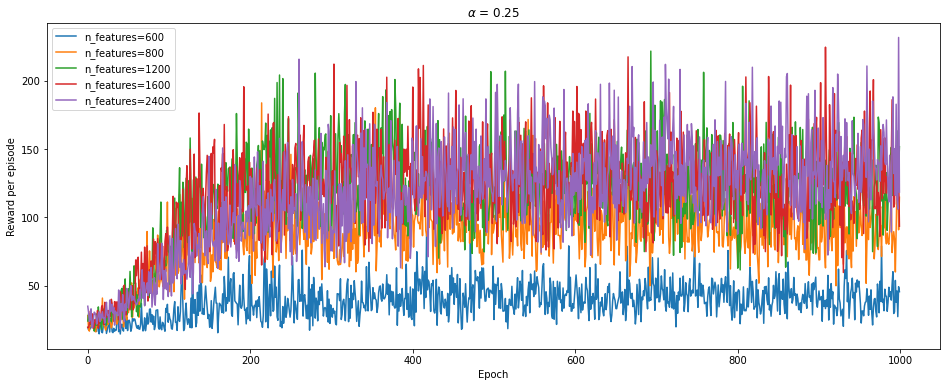

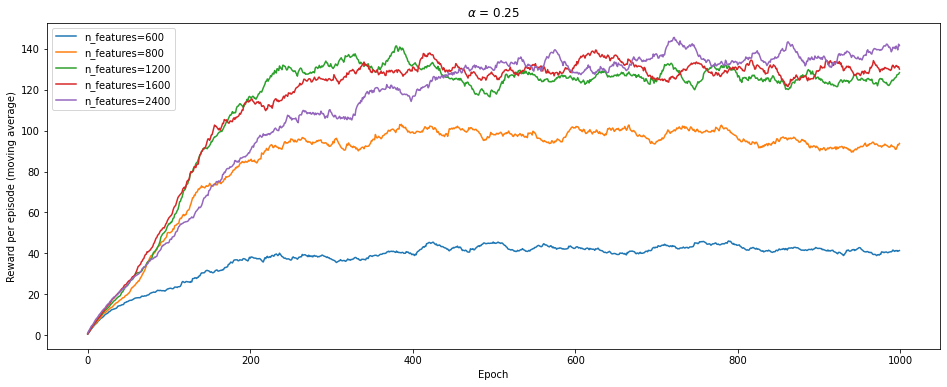

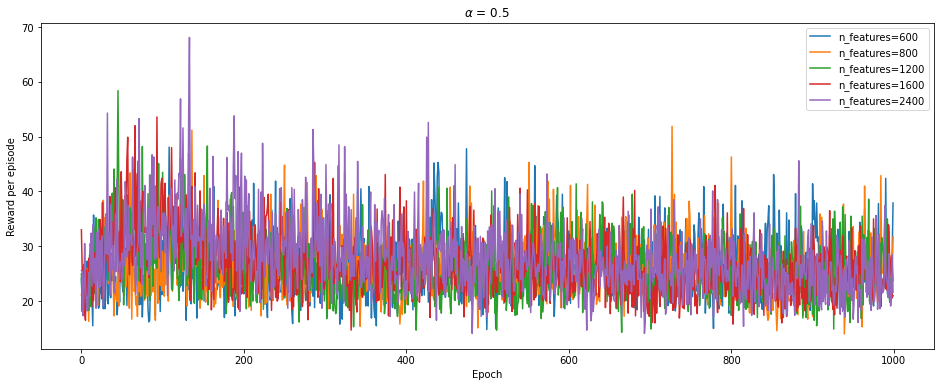

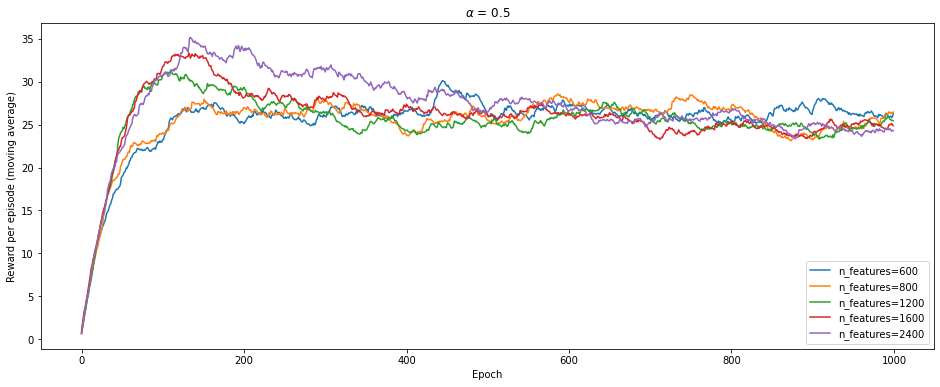

In [ ]:
with open('results/gridsearch_alpha_nfeatures.pickle', 'rb') as file:
    gridsearch_alpha_nfeatures = pickle.load(file)

plt.rcParams['figure.figsize'] = [16, 6]
for alpha in gridsearch_alpha_nfeatures.alpha.unique():
    fig_rewards = plt.figure().number
    fig_mv_avg_rewards = plt.figure().number
    for n_features in gridsearch_alpha_nfeatures[gridsearch_alpha_nfeatures.alpha == alpha].n_features:
        index = (gridsearch_alpha_nfeatures.alpha == alpha) & (gridsearch_alpha_nfeatures.n_features == n_features)
        rewards = gridsearch_alpha_nfeatures[index].rewards_history[0]
        plt.figure(fig_rewards)
        plt.plot(rewards, label=f'n_features={n_features}')
        plt.figure(fig_mv_avg_rewards)
        plt.plot(moving_average(rewards, initial_value=0), label=f'n_features={n_features}')
    plt.figure(fig_rewards)
    plt.xlabel('Epoch')
    plt.ylabel('Reward per episode')
    plt.title(f'$\\alpha$ = {alpha}')
    plt.legend()
    plt.savefig(f'results/rewards_alpha_{alpha}.png')
    plt.figure(fig_mv_avg_rewards)
    plt.xlabel('Epoch')
    plt.ylabel('Reward per episode (moving average)')
    plt.title(f'$\\alpha$ = {alpha}')
    plt.legend()
    plt.savefig(f'results/mv_avg_rewards_alpha_{alpha}.png')

Best Hyper-parameters: {'alpha': 0.1, 'n_features': 2400, 'rewards': 153.2880096435547}


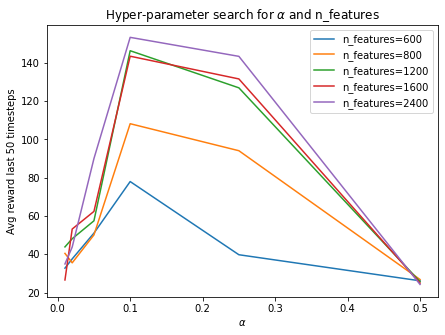

In [ ]:
with open('results/gridsearch_alpha_nfeatures.pickle', 'rb') as file:
    gridsearch_alpha_nfeatures = pickle.load(file)

plt.rcParams['figure.figsize'] = [7, 5]
best_rewards = 0
for n_features in gridsearch_alpha_nfeatures.n_features.unique():
    index = gridsearch_alpha_nfeatures.n_features == n_features
    alphas = gridsearch_alpha_nfeatures[index].alpha
    rewards = torch.Tensor([*gridsearch_alpha_nfeatures[index].rewards_history])[:,-50:].mean(dim=1)
    if rewards.max() > best_rewards:
        best_rewards = rewards.max()
        best_hyperparams = {'alpha':alphas[(rewards == rewards.max()).tolist()].values[0], 'n_features':n_features, 'rewards':best_rewards.item()}
    plt.plot(alphas, rewards, label=f'n_features={n_features}')
plt.xlabel(r'$\alpha$')
plt.ylabel('Avg reward last 50 timesteps')
plt.title(r'Hyper-parameter search for $\alpha$ and n_features')
plt.legend()
plt.savefig('results/gridsearch_alpha_nfeatures.png')

print('Best Hyper-parameters:', best_hyperparams)
plt.show()

In [ ]:
alpha, n_features = 0.1, 2400 #found in previous grid search
# alpha, n_features = best_hyperparams['alpha'], best_hyperparams['n_features'] #found in previous grid search

def plot_many(experiments, label=None, color=None):
    mean_exp = torch.mean(experiments, axis=0)
    std_exp = torch.std(experiments, axis=0)
    plt.plot(mean_exp, color=color, label=label)
    plt.fill_between(range(len(experiments[0])), mean_exp + std_exp, mean_exp - std_exp, color=color, alpha=0.1)

test_betas =  [0.0, 0.05]
epochs = 1000
runs = 20
gridsearch_beta = pd.DataFrame(columns=['alpha', 'n_features', 'beta', 'runs', 'rewards_history'])
plt.rcParams['figure.figsize'] = [16, 6]

for i,beta in enumerate(test_betas):
    rewards = torch.zeros(epochs)
    for j in range(runs):
        print(f'\rGridsearch Beta {i+1}/{len(test_betas)} (alpha={alpha}, n_features={n_features}, beta={beta}, run {j+1}/{runs})', end='')
        env = BinaryEnv('CartPole-v1', n_features=n_features, device=CPU)
        agent = SarsaPhiEBAgent(env, alpha=alpha, beta=beta, device=env.device)
        agent.learn_episodes(epochs, do_print=False)
        rewards += torch.Tensor(agent.rewards)
    rewards /= runs
    gridsearch_beta = gridsearch_beta.append([{'alpha':alpha, 'n_features':n_features, 'beta':beta, 'runs':runs, 'rewards_history':rewards.tolist()}], ignore_index=True)

results_dir = Path('./results')
results_dir.mkdir(exist_ok=True)
with open(results_dir.joinpath('gridsearch_beta.pickle'), 'wb') as file:
    pickle.dump(gridsearch_beta, file)

{'alpha': 0.1, 'n_features': 2400, 'beta': 0.05, 'rewards': 138.55999755859375}


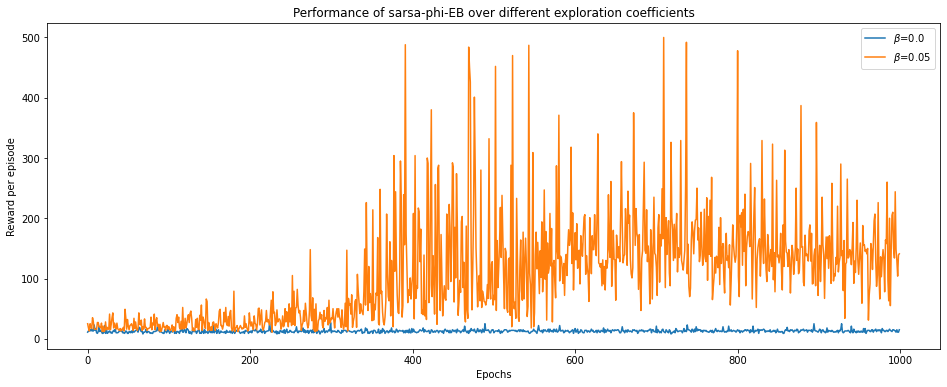

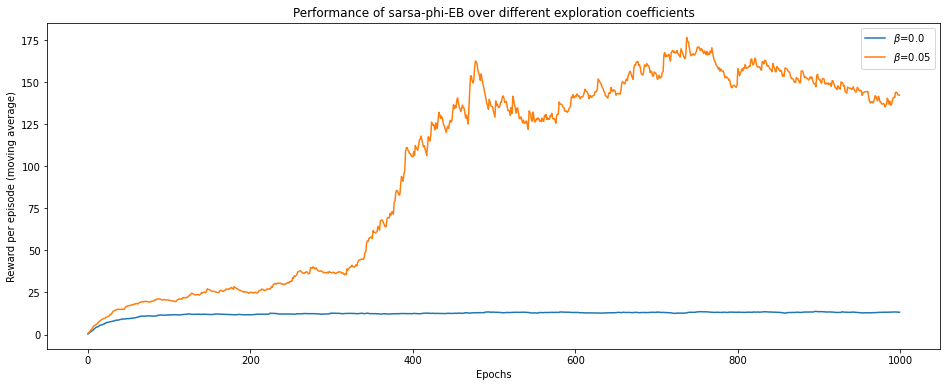

In [ ]:
import torch
import matplotlib.pyplot as plt
import pickle 

with open('results/gridsearch_beta.pickle', 'rb') as file:
    gridsearch_beta = pickle.load(file)

plt.rcParams['figure.figsize'] = [16, 6]
max_rewards = 0
fig_rewards = plt.figure().number
fig_mv_avg_rewards = plt.figure().number
for beta in gridsearch_beta.beta:
    index = gridsearch_beta.beta == beta
    rewards = torch.Tensor(gridsearch_beta[index].rewards_history.values[0])
    if rewards[-50:].mean() > max_rewards:
        max_rewards = rewards[-50:].mean()
        best_hyperparams = {'alpha':gridsearch_beta[index].alpha.iloc[0], 'n_features':gridsearch_beta[index].n_features.iloc[0], 'beta':gridsearch_beta[index].beta.iloc[0], 'rewards':max_rewards.item()}
    plt.figure(fig_rewards)
    plt.plot(rewards, label=f'$\\beta$={beta}')
    plt.figure(fig_mv_avg_rewards)
    # print(rewards)
    # print(moving_average(rewards))
    plt.plot(moving_average(rewards.tolist(), initial_value=0), label=f'$\\beta$={beta}')
        
plt.figure(fig_rewards)
plt.title('Performance of sarsa-phi-EB over different exploration coefficients')
plt.xlabel('Epochs')
plt.ylabel('Reward per episode')
plt.legend()
plt.savefig('results/beta_search.png')
plt.figure(fig_mv_avg_rewards)
plt.title('Performance of sarsa-phi-EB over different exploration coefficients')
plt.xlabel('Epochs')
plt.ylabel('Reward per episode (moving average)')
plt.legend()
plt.savefig('results/beta_search.png')

print(best_hyperparams)
# plt.show()

# beta_avg = np.mean(beta_grid[:,-50:], axis=1)
# print(beta_avg)
# [best_beta] = np.where(beta_avg == beta_avg.max())
# print(best_beta)